# Восстановление золота из руды

## Описание проекта
Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

---

<h2>Содержание</h2>

<div class="toc">
  <ul>
    <li><a href="#Подготовка-данных">Подготовка данных</a></li>
    <li><a href="#Анализ-данных">Анализ данных</a></li>
      <ul>
        <li><a href="#Концентрация-металлов-(Au,-Ag,-Pb)-на-различных-этапах-очистки">Концентрация металлов (Au, Ag, Pb) на различных этапах очистки</a></li>
        <li><a href="#Сравнение-распределения-размеров-гранул-сырья-на-обучающей-и-тестовой-выборках">Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках</a></li>
        <li><a href="#Суммарная-концентрация-всех-веществ-на-разных-стадиях">Суммарная концентрация всех веществ на разных стадиях</a></li>
      </ul>      
    <li><a href="#Модель">Модель</a></li>
       <ul>
        <li><a href="#Обучение-разных-моделей-и-оценка-их-качества">Обучение разных моделей и оценка их качества</a></li>
        <li><a href="#Проверка-на-тестовой-выборке">Проверка на тестовой выборке</a></li>
      </ul>    
    <li><a href="#Общий-вывод">Общий вывод</a></li>
  </ul>
</div>

<style>
  .toc ul {
    font-size: 14px;
  }
</style>

---

### Цели и задачи

**Цель** - Подготовить прототип модели машинного обучения, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды.

**Задачи**:
    
    1. Загрузить и осмотреть данные.
        1.1 Проверить, что эффективность обогащения рассчитана правильно.
        1.2 Проанализировать признаки, недоступные в тестовой выборке.
        1.3 Провести предобработку данных.
        
    2. Проанализировать данные.
        2.1 Посмотреть, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.
        2.2 Сравнить распределения размеров гранул исходного сырья на обучающей и тестовой выборках.
        2.3 Исследовать суммарную концентрацию металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.
        
    3. Построить модель.
        3.1 Написать функцию для вычисления итоговой sMAPE.
        3.2 Обучите разные модели и оценить их качество кросс-валидацией.
        3.3 Выбрать лучшую модель и проверить её на тестовой выборке.
        
    4. Сделать выводы по итогам работы.
    
---
    
### Описание данных

#### Технологический процесс
* `Rougher feed` — исходное сырье
* `Rougher additions` (или reagent additions) — флотационные реагенты: `Xanthate`, `Sulphate`, `Depressant`
* * `Xanthate` — ксантогенат (промотер, или активатор флотации);
* * `Sulphate` — сульфат (на данном производстве сульфид натрия);
* * `Depressant` — депрессант (силикат натрия).


* `Rougher process` (англ. «грубый процесс») — флотация
* `Rougher tails` — отвальные хвосты
* `Float banks` — флотационная установка
* `Cleaner process` — очистка
* `Rougher Au` — черновой концентрат золота
* `Final Au` — финальный концентрат золота

#### Параметры этапов
* `air amount` — объём воздуха
* `fluid levels` — уровень жидкости
* `feed size` — размер гранул сырья
* `feed rate` — скорость подачи

#### Наименование признаков
Наименование признаков должно быть такое: `[этап].[тип_параметра].[название_параметра]`

Пример: `rougher.input.feed_ag`

Возможные значения для блока `[этап]`:

* `rougher` — флотация
* `primary_cleaner` — первичная очистка
* `secondary_cleaner` — вторичная очистка
* `final` — финальные характеристики

Возможные значения для блока `[тип_параметра]`:

* `input` — параметры сырья
* `output` — параметры продукта
* `state` — параметры, характеризующие текущее состояние этапа
* `calculation` — расчётные характеристики

---

## Подготовка данных

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [2]:
STATE = 54321

Датасеты:

* gold_recovery_full_new.csv — исходные данные.
* gold_recovery_train_new.csv — обучающая выборка.
* gold_recovery_test_new.csv — тестовая выборка.

In [3]:
df_full = pd.read_csv("/datasets/gold_recovery_full_new.csv")
df_train = pd.read_csv("/datasets/gold_recovery_train_new.csv")
df_test = pd.read_csv("/datasets/gold_recovery_test_new.csv")

In [4]:
# Знакомимся с данными
def data_view (data):
    data.info()
    display(data.head())
    print('\nЧисло дубликатов:', data.duplicated().sum())

In [5]:
data_view (df_full)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691



Число дубликатов: 0


In [6]:
data_view (df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691



Число дубликатов: 0


In [7]:
data_view (df_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333



Число дубликатов: 0


### Рассчитаем эффективность обогащения чернового концентрата rougher.output.recovery (MAE)
Эффективность обогащения рассчитывается по следующей формуле

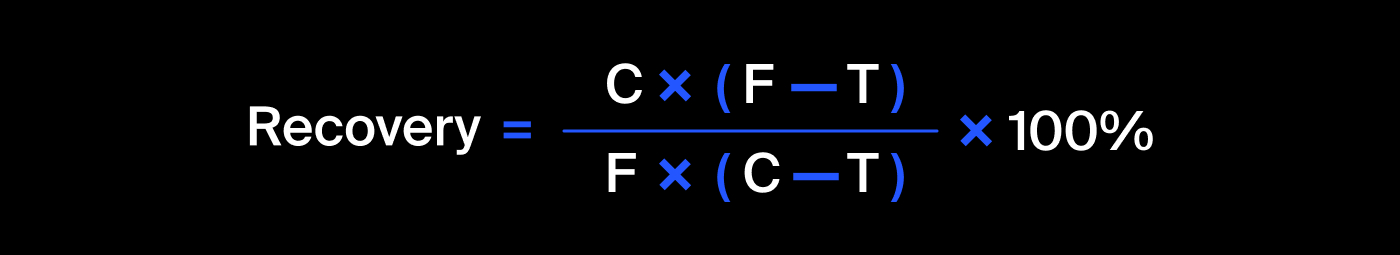

где:
* C — доля золота в концентрате после флотации/очистки (*rougher.output.concentrate_ag*);
* F — доля золота в сырье/концентрате до флотации/очистки (*rougher.input.feed_ag*);
* T — доля золота в отвальных хвостах после флотации/очистки (*rougher.output.tail_ag*).

In [8]:
c = df_train['rougher.output.concentrate_au']
f = df_train['rougher.input.feed_au']
t = df_train['rougher.output.tail_au']

recovery = ((c*(f-t))/(f*(c-t))) * 100

display(recovery)
display(df_train['rougher.output.recovery'])

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Length: 14149, dtype: float64

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Name: rougher.output.recovery, Length: 14149, dtype: float64

In [9]:
print('MAE =', mean_absolute_error(df_train['rougher.output.recovery'], recovery))

MAE = 9.73512347450521e-15


MAE имеет малое отклонение - это значит, что расчетное значение *rougher.output.recovery* совпадает с данными из столбца.

### Найдем все столбцы, которые есть в тренировочной выборке, но нет в тестовой.

In [10]:
missed_columns = set(df_train) - set(df_test)
display(missed_columns)
print ("Количество столбцов:", len(missed_columns))

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Количество столбцов: 34


* Заметим, что из 34 пропущенных признака 30 относятся к параметрам продукта (*output*) и только 4 к расчетным характеристикам (*calculation*). 
* Так же на всех этапах отсутствует информация о отвальных хвостов (*tail*) и концентрате (*concentrate*).
* На всех этапах отсутствует информация о параметрах, характеризующих текущее состояние этапа (*state*).

### Проведем предобработку данных

* Приведу столбец *date* изменив тип данных из "object" в "datetime" для заполнения пропусков, в остальном типы данных соответствует содержимому. В дальнейшем он нам не понадобится, поэтому позже удалю его.
* Пропуски заполню значениями предшествующими по времени (исходя из задачи). 
* В тестовой выборки отсутствуют целевые признаки *rougher.output.recovery* и *final.output.recovery*, которые будут нужны для расчета метрики качества. Добавим их.

In [14]:
df_train["date"] = pd.to_datetime(df_train["date"], format='%Y-%m-%d %H:%M:%S')# формат даты
df_test["date"] = pd.to_datetime(df_test["date"], format='%Y-%m-%d %H:%M:%S')# формат даты
df_full["date"] = pd.to_datetime(df_test["date"], format='%Y-%m-%d %H:%M:%S')# формат даты

df_test = df_test.merge(df_full.loc[:, ['date','rougher.output.recovery','final.output.recovery']], on='date') # добавляем столбец

df_train = df_train.fillna(method="ffill", axis=0) # пропуск
df_train = df_train.drop('date', axis=1) # удаляю

df_test = df_test.fillna(method="ffill", axis=0) # пропуск
df_test = df_test.drop('date', axis=1) # удаляю

display(df_train.info())
display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14149 non-null  float64
 1   final.output.concentrate_pb                         14149 non-null  float64
 2   final.output.concentrate_sol                        14149 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14149 non-null  float64
 7   final.output.tail_sol                               14149 non-null  float64
 8   final.output.tail_au                                14149 non-null  float64


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5289
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5290 non-null   float64
 1   primary_cleaner.input.depressant            5290 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5290 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null   float64
 10  primary_clea

None

### Вывод
* Рассчитали эффективность обогащения чернового концентрата *rougher.output.recovery* (MAE). MAE имеет малое отклонение.
* Проведен анализ признаков, отсутсвующих в тестовой выборке.
* Проведена предобработка данных, заполнены пропуски, удален не информативный столбец (*date*).

## Анализ данных

### Концентрация металлов (Au, Ag, Pb) на различных этапах очистки

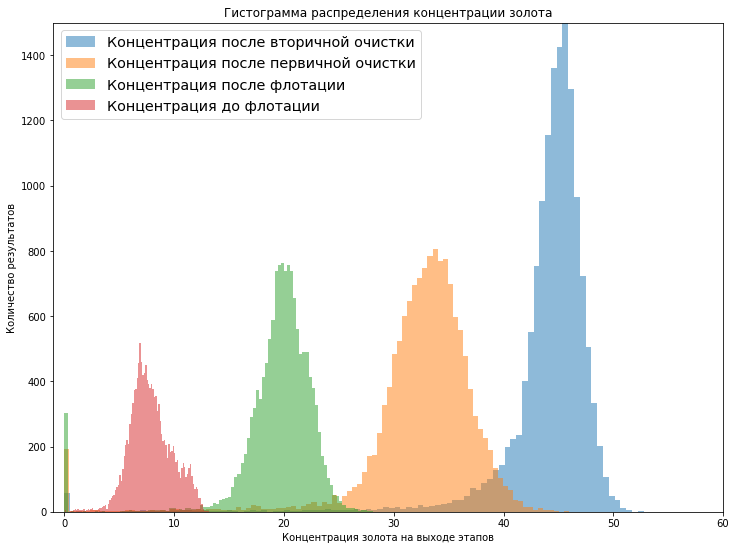

In [15]:
# Золото
plt.figure(figsize=[12,9])

plt.hist(df_train['final.output.concentrate_au'], bins=100, label = 'Концентрация после вторичной очистки', alpha=.5)
plt.hist(df_train['primary_cleaner.output.concentrate_au'], bins=100, label = 'Концентрация после первичной очистки', alpha=.5)
plt.hist(df_train['rougher.output.concentrate_au'], bins=100, label = 'Концентрация после флотации', alpha=.5)
plt.hist(df_train['rougher.input.feed_au'], bins=100, label = 'Концентрация до флотации', alpha=.5)

plt.xlim([-1, 60])
plt.ylim([0, 1500])

plt.xlabel("Концентрация золота на выходе этапов")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Гистограмма распределения концентрации золота")
plt.show()

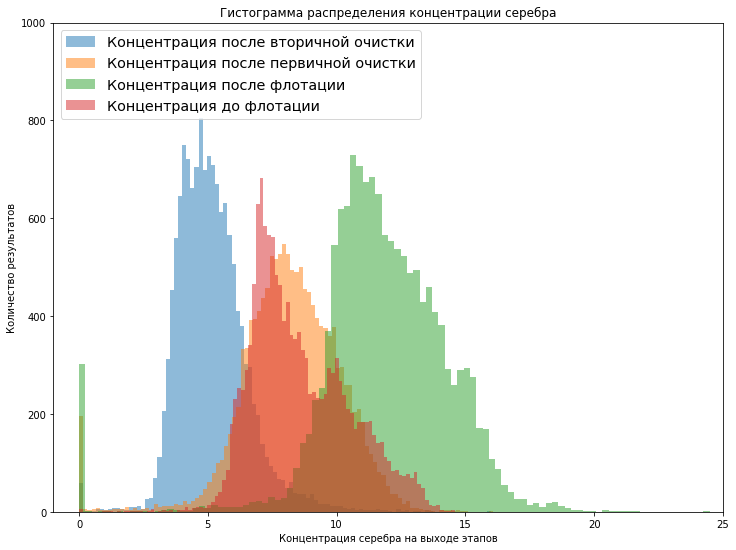

In [16]:
# Серебро
plt.figure(figsize=[12,9])

plt.hist(df_train['final.output.concentrate_ag'], bins=100, label = 'Концентрация после вторичной очистки', alpha=.5)
plt.hist(df_train['primary_cleaner.output.concentrate_ag'], bins=100, label = 'Концентрация после первичной очистки', alpha=.5)
plt.hist(df_train['rougher.output.concentrate_ag'], bins=100, label = 'Концентрация после флотации', alpha=.5)
plt.hist(df_train['rougher.input.feed_ag'], bins=100, label = 'Концентрация до флотации', alpha=.5)

plt.xlim([-1, 25])
plt.ylim([0, 1000])

plt.xlabel("Концентрация серебра на выходе этапов")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Гистограмма распределения концентрации серебра")
plt.show()

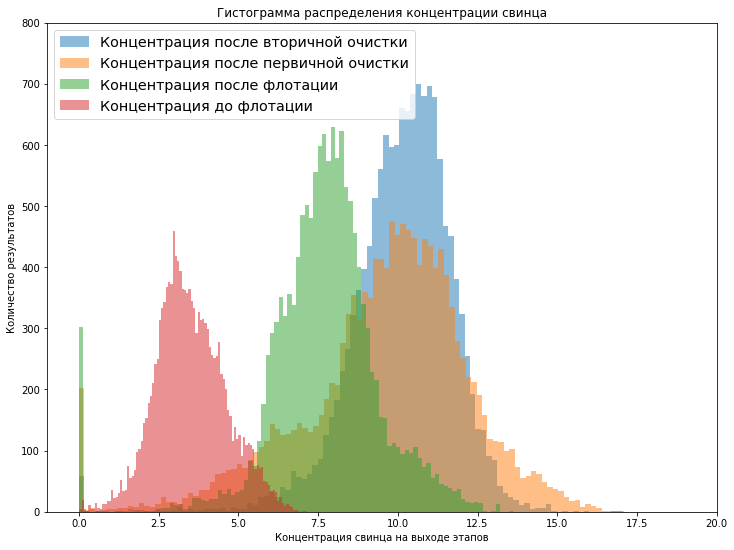

In [17]:
# Свинец
plt.figure(figsize=[12,9])

plt.hist(df_train['final.output.concentrate_pb'], bins=100, label = 'Концентрация после вторичной очистки', alpha=.5)
plt.hist(df_train['primary_cleaner.output.concentrate_pb'], bins=100, label = 'Концентрация после первичной очистки', alpha=.5)
plt.hist(df_train['rougher.output.concentrate_pb'], bins=100, label = 'Концентрация после флотации', alpha=.5)
plt.hist(df_train['rougher.input.feed_pb'], bins=100, label = 'Концентрация до флотации', alpha=.5)

plt.xlim([-1, 20])
plt.ylim([0, 800])

plt.xlabel("Концентрация свинца на выходе этапов")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Гистограмма распределения концентрации свинца")
plt.show()

* На гистограмме видим что концентарция золота (Au) повышается с каждым этапом. То есть с помощью флотации мы обогащаем золото.
* Доля серебра (Ag) увеличивается на этапе флотации, а затем постепенно уменьшается.
* Доля свинца (Pb) сначала увеличивается на этапе флотации и после первичной очиcтки, затем остатется примерно на одном уровне.
* Нулевые значения, это либо выбросы, либо концентрация стремится к нулю (здесь я не силен в химии 🤓, на сколько сегодня технологический процесс силен, я не знаю). Удалю.

### Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

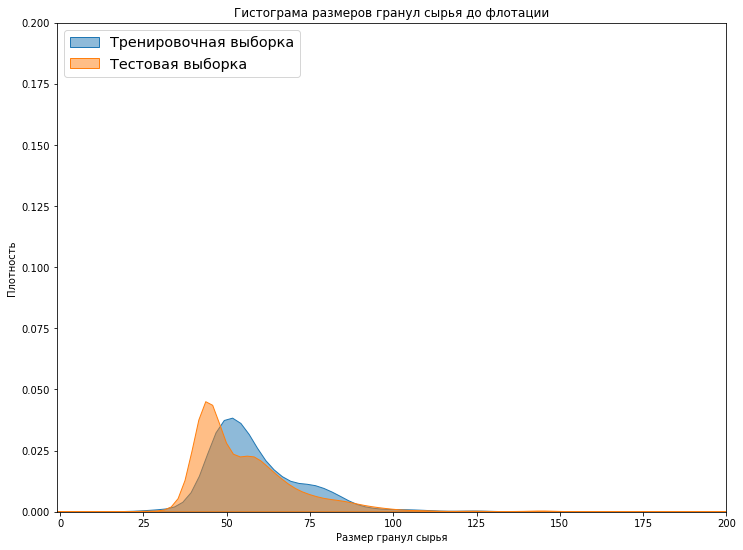

In [18]:
# До флотации
plt.figure(figsize=[12,9])

sns.kdeplot(df_train['rougher.input.feed_size'], fill=True, common_norm=False, palette="crest", alpha=.5)
sns.kdeplot(df_test['rougher.input.feed_size'], fill=True, common_norm=False, palette="crest", alpha=.5)

plt.xlim([-1, 200])
plt.ylim([0, 0.2])

plt.xlabel("Размер гранул сырья")
plt.ylabel("Плотность")

plt.legend(("Тренировочная выборка", "Тестовая выборка"), loc='upper left', fontsize='x-large')

plt.title("Гистограма размеров гранул сырья до флотации")
plt.show()

Размер гранул имеет достаточно сильный разброс значений в среднем от 25 до 125+, что предполагает крупную смесь золотосодержащей руды. Наблюдается различие между распределениями выборок, но оно, по моему мнению, в пределах нормы.

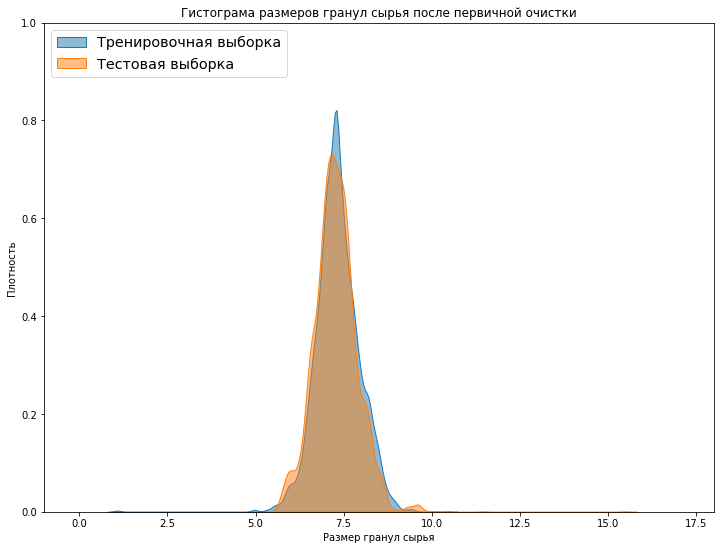

In [19]:
# После первичной очистки
plt.figure(figsize=[12,9])

sns.kdeplot(df_train['primary_cleaner.input.feed_size'], fill=True, common_norm=False, palette="crest", alpha=.5)
sns.kdeplot(df_test['primary_cleaner.input.feed_size'], fill=True, common_norm=False, palette="crest", alpha=.5)

plt.xlim([-1, 18])
plt.ylim([0, 1])

plt.xlabel("Размер гранул сырья")
plt.ylabel("Плотность")

plt.legend(("Тренировочная выборка", "Тестовая выборка"), loc='upper left', fontsize='x-large')

plt.title("Гистограма размеров гранул сырья после первичной очистки")
plt.show()

В целом видим нормальное распеделение, размер гранул после первичной очистки нормализовался.

### Суммарная концентрация всех веществ на разных стадиях

In [20]:
rougher_input = 0
rougher_output = 0
final_output = 0

for i in ['au', 'ag', 'pb', 'sol']:
    rougher_input += df_train[f'rougher.input.feed_{i}']
    rougher_output += df_train[f'rougher.output.concentrate_{i}']
    final_output += df_train[f'final.output.concentrate_{i}']  

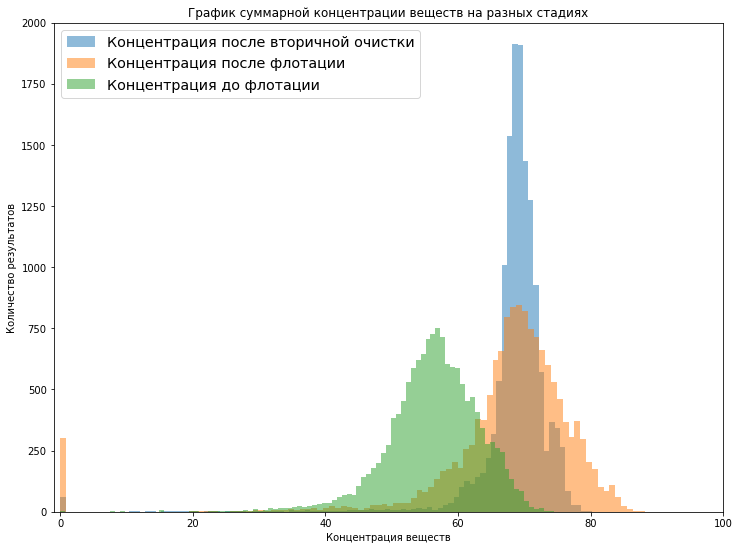

In [21]:
plt.figure(figsize=[12,9])

plt.hist(final_output, bins=100, label = 'Концентрация после вторичной очистки', alpha=.5)
plt.hist(rougher_output, bins=100, label = 'Концентрация после флотации', alpha=.5)
plt.hist(rougher_input, bins=100, label = 'Концентрация до флотации', alpha=.5)


plt.xlim([-1, 100])
plt.ylim([0, 2000])

plt.xlabel("Концентрация веществ")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("График суммарной концентрации веществ на разных стадиях")
plt.show()

* Суммарная концентрация веществ увеличивается к финальному этапу, а диапазон распределения суммарной концентрации веществ уменьшается.
* Здесь выбросы точно можно удалить.

In [22]:
for i in ['au', 'ag', 'pb', 'sol']:
    df_train = df_train.drop(df_train[df_train[f'rougher.input.feed_{i}'] == 0].index, axis = 0)
    df_train = df_train.drop(df_train[df_train[f'rougher.output.concentrate_{i}'] == 0].index, axis = 0)
    df_train = df_train.drop(df_train[df_train[f'final.output.concentrate_{i}'] == 0].index, axis = 0)
    df_train = df_train.drop(df_train[df_train[f'primary_cleaner.output.concentrate_{i}'] == 0].index, axis = 0)
    
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13716 entries, 0 to 14148
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         13716 non-null  float64
 1   final.output.concentrate_pb                         13716 non-null  float64
 2   final.output.concentrate_sol                        13716 non-null  float64
 3   final.output.concentrate_au                         13716 non-null  float64
 4   final.output.recovery                               13716 non-null  float64
 5   final.output.tail_ag                                13716 non-null  float64
 6   final.output.tail_pb                                13716 non-null  float64
 7   final.output.tail_sol                               13716 non-null  float64
 8   final.output.tail_au                                13716 non-null  float64


Удалена допустимая доля выборки.

### Вывод
* Концентарция золота (Au) и свинца (Pb) повышается с каждым этапом (кроме последнего этапа для свинца). Доля же серебра (Ag) сокращается.
* Размер гранул после обработки стремиться к "нормальному", где выборки имеют равное распределение. До обработки размер гранул достаточно различен, выборки распределены не равномерно, но в пределах нормы.  
* С каждым этапом суммарная концентрация веществ увеличивается в финальному этапу.

## Модель

### Функция для вычисления итоговой sMAPE

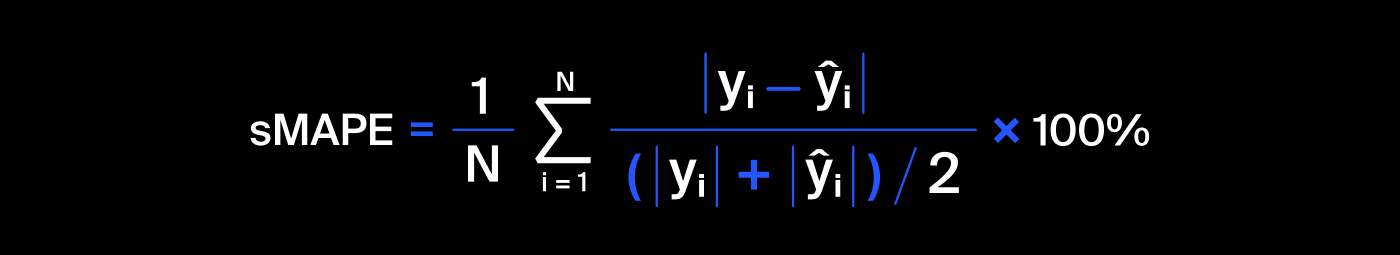

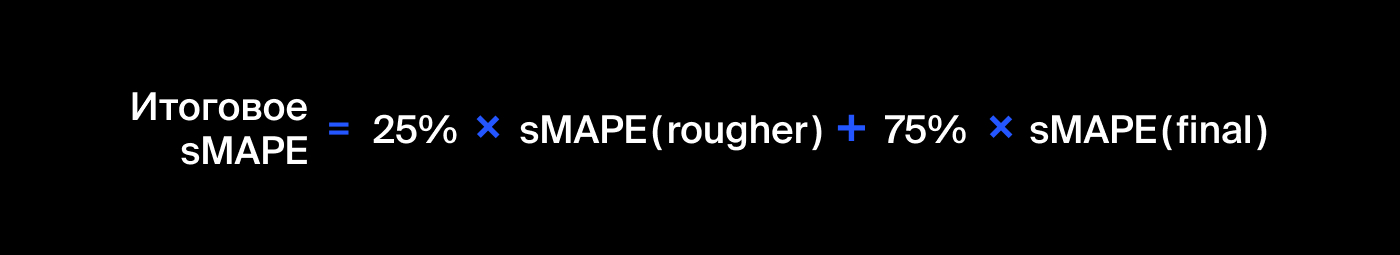

In [23]:
# sMAPE
def smape_result (target, predict):
    smape = np.mean(abs(target-predict) / ((abs(target) + abs(predict))/2)) * 100
    return smape

In [24]:
# итоговое sMAPE
def smape_final (sMAPE_rougher, sMAPE_final):
    final = 0.25*sMAPE_rougher + 0.75*sMAPE_final
    return final

### Обучение разных моделей и оценка их качества

Удаляю отсутствующие в тестовой выборке признаки (за исключением целевых признаков) из тренировочной выборки. В противном случае в ходе обучения будущих моделей может произойти утечка целевого признака.

In [25]:
columns_for_delete = missed_columns - set(['rougher.output.recovery','final.output.recovery'])
df_train = df_train.drop(columns=columns_for_delete, axis=1)

In [26]:
target_rougher = df_train['rougher.output.recovery'] #целевой признак
target_final = df_train['final.output.recovery'] #целевой признак

features = df_train.drop(['rougher.output.recovery','final.output.recovery'], axis=1) # признаки

In [27]:
# Качество
smape_score = make_scorer(smape_result, greater_is_better=False)

In [28]:
# Модели
model_1 = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=STATE))
model_2 = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=STATE))
model_3 = make_pipeline(StandardScaler(), LinearRegression())

In [29]:
# гиперпараметры моделй
parameters_RF = {"randomforestregressor__n_estimators":[5,100],
                 "randomforestregressor__max_depth":[1,30]}
parameters_DT= {"decisiontreeregressor__max_depth":[1,50]}

In [30]:
# GridSearch
grid_rougher_RF = GridSearchCV(model_1, 
                               param_grid = parameters_RF, 
                               scoring=smape_score,
                               cv=8,
                               n_jobs=-1)
grid_final_RF = GridSearchCV(model_1, 
                             param_grid = parameters_RF, 
                             scoring=smape_score,
                             cv=8,
                             n_jobs=-1)

grid_rougher_DT = GridSearchCV(model_2, 
                               param_grid = parameters_DT, 
                               scoring=smape_score,
                               cv=8,
                               n_jobs=-1)
grid_final_DT = GridSearchCV(model_2, 
                             param_grid = parameters_DT, 
                             scoring=smape_score,
                             cv=8,
                             n_jobs=-1)

#### Обучение

In [31]:
%%time
grid_rougher_DT.fit(features, target_rougher)

CPU times: user 8.72 s, sys: 21 ms, total: 8.74 s
Wall time: 8.98 s


GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=54321))]),
             n_jobs=-1,
             param_grid={'decisiontreeregressor__max_depth': [1, 50]},
             scoring=make_scorer(smape_result, greater_is_better=False))

In [32]:
%%time
grid_final_DT.fit(features, target_final)

CPU times: user 8.57 s, sys: 8.01 ms, total: 8.57 s
Wall time: 8.58 s


GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=54321))]),
             n_jobs=-1,
             param_grid={'decisiontreeregressor__max_depth': [1, 50]},
             scoring=make_scorer(smape_result, greater_is_better=False))

In [33]:
%%time
grid_rougher_RF.fit(features, target_rougher)

CPU times: user 8min 11s, sys: 740 ms, total: 8min 11s
Wall time: 8min 12s


GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=54321))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [1, 30],
                         'randomforestregressor__n_estimators': [5, 100]},
             scoring=make_scorer(smape_result, greater_is_better=False))

In [34]:
%%time
grid_final_RF.fit(features, target_final)

CPU times: user 8min 59s, sys: 1.18 s, total: 9min
Wall time: 9min


GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=54321))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [1, 30],
                         'randomforestregressor__n_estimators': [5, 100]},
             scoring=make_scorer(smape_result, greater_is_better=False))

In [35]:
%%time

LR_rougher = cross_val_score(model_3,
                          features,
                          target_rougher,
                          scoring=smape_score,
                          cv=8,
                          n_jobs=-1)

LR_final = cross_val_score(model_3,
                        features,
                        target_final,
                        scoring=smape_score,
                        cv=8,
                        n_jobs=-1)

CPU times: user 2.11 s, sys: 2.48 s, total: 4.6 s
Wall time: 4.54 s


In [36]:
# смотрим качество
best_score_rougher_RF = grid_rougher_RF.best_score_
best_score_final_RF = grid_final_RF.best_score_

best_score_rougher_DT = grid_rougher_DT.best_score_
best_score_final_DT = grid_final_DT.best_score_

final_LR_rougher = LR_rougher.mean()
final_LR_final = LR_final.mean()

In [39]:
# выводим результаты
comparison_tabl = pd.DataFrame(index=['rougher_sMAPE','final_sMAPE', 'Итоговое sMAPE'], columns=['RandomForest','DecisionTree','LinearRegression'])
comparison_tabl['RandomForest'] = round (best_score_rougher_RF*(-1), 2), round(best_score_final_RF*(-1), 2), round(smape_final(best_score_rougher_RF, best_score_final_RF)*(-1), 2)
comparison_tabl['DecisionTree'] = round (best_score_rougher_DT*(-1), 2), round(best_score_final_DT*(-1), 2), round(smape_final(best_score_rougher_DT, best_score_final_DT)*(-1), 2)
comparison_tabl['LinearRegression'] = round (final_LR_rougher*(-1), 2), round(final_LR_final*(-1), 2), round(smape_final(final_LR_rougher, final_LR_final)*(-1), 2)
comparison_tabl

,RandomForest,DecisionTree,LinearRegression
rougher_sMAPE,6.47,8.53,6.46
final_sMAPE,9.47,9.89,10.74
Итоговое sMAPE,8.72,9.55,9.67


Лучшая модель - RandomForestRegression, ее будем проверять на тестовой выборке

In [40]:
target_rougher_test = df_test['rougher.output.recovery'] #целевой признак
target_final_test = df_test['final.output.recovery'] #целевой признак

features_test = df_test.drop(['rougher.output.recovery','final.output.recovery'], axis=1) # признаки

### Проверка на тестовой выборке

In [41]:
print("Лучшие гиперпараметры леса")
print("rougher:", grid_rougher_RF.best_params_)
print("final:", grid_final_RF.best_params_)

Лучшие гиперпараметры леса
rougher: {'randomforestregressor__max_depth': 30, 'randomforestregressor__n_estimators': 100}
final: {'randomforestregressor__max_depth': 30, 'randomforestregressor__n_estimators': 100}


In [43]:
%%time
test_rougher = grid_rougher_RF.best_estimator_
test_final = grid_final_RF.best_estimator_

predicted_rougher = test_rougher.predict(features_test)
predicted_final = test_final.predict(features_test)

#считаем sMAPE
smape_test_rougher = smape_result (target_rougher_test, predicted_rougher)
smape_test_final = smape_result (target_final_test, predicted_final)

complete_smape_for_test = smape_final(smape_test_rougher, smape_test_final)
print("RandomForestRegressor:", round(complete_smape_for_test, 2))

RandomForestRegressor: 12.66
CPU times: user 157 ms, sys: 4.01 ms, total: 161 ms
Wall time: 160 ms


Проверим полученную модель на адекватность. Вычислим показатель sMape для константной модели и сравним с результатами лучшей модели.

In [47]:
dummy = DummyRegressor(strategy="median").fit(features, target_rougher)
dummy_final = DummyRegressor(strategy="median").fit(features, target_final)

dummy_pred = dummy.predict(features_test)
dummy_final_pred = dummy_final.predict(features_test)

In [48]:
dummy_result = smape_final(smape_result(target_rougher_test, dummy_pred), smape_result(target_final_test, dummy_final_pred))

In [49]:
# выводим результаты
comparison_tabl = pd.DataFrame(index=['Итоговое sMAPE'], columns=['RandomForestRegressor', 'DummyRegressor'])
comparison_tabl['RandomForestRegressor'] = round (complete_smape_for_test, 2)
comparison_tabl['DummyRegressor'] = round (dummy_result, 2)
comparison_tabl

,RandomForestRegressor,DummyRegressor
Итоговое sMAPE,12.66,11.39


### Вывод 
* Итоговая модель построена на алгоритме *RandomForest*
* Заметно, что разность метрик качества (константной и нашей модели) - не слишком большая. Такое расхождение метрик допустимо в этом проекте. 

## Общий вывод
* Параметр recovery на обучающей выборке был рассчитан верно.
* Исследована концетрация металов на различных этапах очистки, а так же размер гранул.
* Построена модель с лучшими результатами прогноза - *RandomForestRegressor*.
* Модель проверена на адекватность.

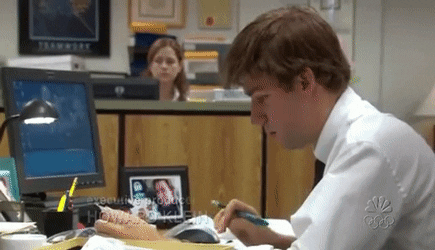